# Predicting The Stock Market

In this project, we'll be working with data from the [S&P500 Index](https://en.wikipedia.org/wiki/S%26P_500_Index).

We will be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

We'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
- Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.

We'll be using this dataset to develop a predictive model. We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

In [16]:
import pandas as pd

df = pd.read_csv('sphist.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


Now, lets convet the Date Column in to datetime format

In [17]:
from datetime import datetime

df['Date'] = pd.to_datetime(df['Date'])



 This will generate dataframe that tells you if each item in the Date column is after 2015-04-01

In [18]:
df[df['Date'] > datetime(year = 2015, month =4, day=1)]

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883
...,...,...,...,...,...,...,...
168,2015-04-09,2081.290039,2093.310059,2074.290039,2091.179932,3.172360e+09,2091.179932
169,2015-04-08,2076.939941,2086.689941,2073.300049,2081.899902,3.265330e+09,2081.899902
170,2015-04-07,2080.790039,2089.810059,2076.100098,2076.330078,3.065510e+09,2076.330078
171,2015-04-06,2064.870117,2086.989990,2056.520020,2080.620117,3.302970e+09,2080.620117


Sorting the dataframe on the Date column. It's currently in descending order, but we'll want it to be in ascending order for some of the next steps. 

In [19]:
df = df.sort_values('Date').reset_index()
df.head()

,index,Date,Open,High,Low,Close,Volume,Adj Close
0,16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1,16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
2,16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
3,16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
4,16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      16590 non-null  int64         
 1   Date       16590 non-null  datetime64[ns]
 2   Open       16590 non-null  float64       
 3   High       16590 non-null  float64       
 4   Low        16590 non-null  float64       
 5   Close      16590 non-null  float64       
 6   Volume     16590 non-null  float64       
 7   Adj Close  16590 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 1.0 MB


##  Generating indicators

Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes time to make predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

This means we have to be extra careful to not inject "future" knowledge into past rows when we do training and prediction. Injecting future knowledge will make our model look good when we are training and testing it, but will make it fail in the real world. This is how many algorithmic traders lose money.

In [21]:
#Calculate the mean for the past 5, 30, 365 days
df['day_5'] = df['Close'].rolling(5).mean().shift(1)
df['day_30'] = df['Close'].rolling(30).mean().shift(1)
df['day_365'] = df['Close'].rolling(365).mean().shift(1)

#Calculate the STD for the past 5, 365 days
df['std_5'] = df['Close'].rolling(5).std().shift(1)
df['std_365'] = df['Close'].rolling(365).std().shift(1)

#Calculate the mean volume for the past 5, 365 days
df['day_5_volume'] = df['Volume'].rolling(5).mean().shift(1)
df['day_365_volume'] = df['Volume'].rolling(365).mean().shift(1)

#Calculate the STD of the average volume over the past five days
df['5_volume_std'] = df['day_5_volume'].rolling(5).std().shift(1)

In [22]:
df.head(10)

,index,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
0,16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN,0.157956,NaN,2046000.0,NaN,NaN
6,16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN,0.089051,NaN,2226000.0,NaN,NaN
7,16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN,0.067602,NaN,2374000.0,NaN,NaN
8,16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN,0.134796,NaN,2458000.0,NaN,NaN
9,16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN,0.196545,NaN,2722000.0,NaN,NaN


In [23]:
df.tail(10)


,index,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
16580,9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,2071.523974,2061.892989,2033.605890,18.246940,64.911334,3.930538e+09,3.523622e+09,6.821252e+07
16581,8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,2078.204004,2064.197327,2034.018028,15.807754,64.768328,3.899886e+09,3.526334e+09,6.979154e+07
16582,7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,2085.943994,2067.045658,2034.432712,3.491188,64.634873,3.791402e+09,3.528961e+09,7.278537e+07
16583,6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,2087.002002,2070.199996,2034.835123,3.395982,64.514871,3.576712e+09,3.528637e+09,1.077890e+08
16584,5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,2088.776025,2072.408333,2035.199864,1.309055,64.449800,3.144458e+09,3.524258e+09,1.652146e+08
16585,4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178,3.916109,64.370261,3.207544e+09,3.527800e+09,3.241733e+08
16586,3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082,7.956808,64.352527,3.232372e+09,3.526090e+09,3.390314e+08
16587,2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356,9.333599,64.277554,3.245514e+09,3.529468e+09,2.803620e+08
16588,1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343,19.599946,64.121622,3.536224e+09,3.532802e+09,1.696382e+08
16589,0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2036.869425,19.806136,64.058862,4.085838e+09,3.535838e+09,1.520693e+08


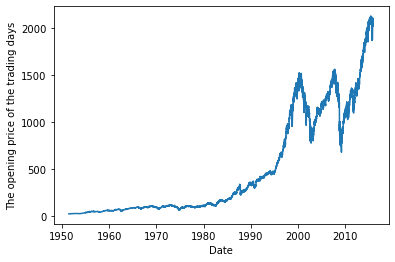

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(df['Date'],df['Open'])
plt.xlabel('Date')
plt.ylabel('The opening price of the trading days')
plt.show()

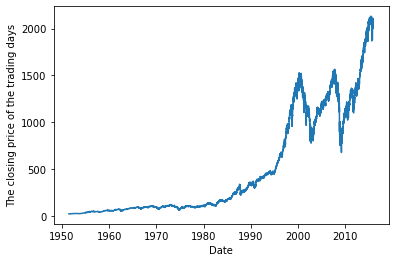

In [56]:
plt.plot(df['Date'],df['Close'])
plt.xlabel('Date')
plt.ylabel('The closing price of the trading days')
plt.show()

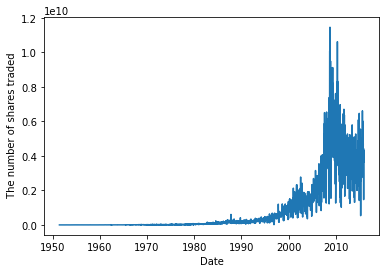

In [57]:
plt.plot(df['Date'],df['Volume'])
plt.xlabel('Date')
plt.ylabel(' The number of shares traded')
plt.show()

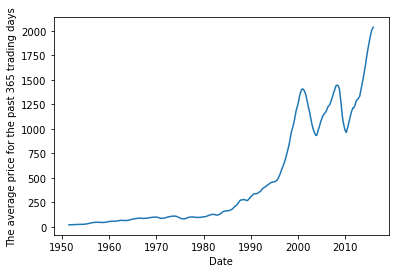

In [58]:
plt.plot(df['Date'],df['day_365'])
plt.xlabel('Date')
plt.ylabel('The average price for the past 365 trading days')
plt.show()

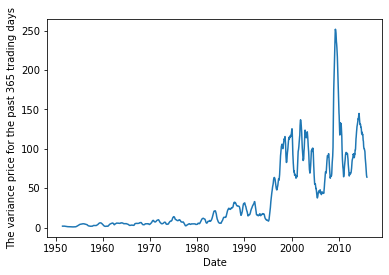

In [59]:
plt.plot(df['Date'],df['std_365'])
plt.xlabel('Date')
plt.ylabel('The variance price for the past 365 trading days')
plt.show()

##  Splitting up the data

Since we are computing indicators that use historical data, there are some rows where there isn't enough historical data to generate them. Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, any rows that fall before 1951-01-03 don't have enough historical data to compute all the indicators. We will need to remove these rows before you split the data.

In [24]:
df = df[df['Date'] > datetime(year = 1951, month = 1, day = 3)]
df.head()

,index,Date,Open,High,Low,Close,Volume,Adj Close,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
251,16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.514000,19.842666,NaN,0.204524,NaN,3268000.0,NaN,88978.649124
252,16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.628000,19.874000,NaN,0.214057,NaN,3358000.0,NaN,74573.453722
253,16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,20.726001,19.907000,NaN,0.181879,NaN,3324000.0,NaN,116421.647472
254,16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,20.840001,19.935000,NaN,0.117047,NaN,3192000.0,NaN,127491.176165
255,16334,1951-01-10,20.850000,20.850000,20.850000,20.850000,3270000.0,20.850000,20.910001,19.961667,NaN,0.161090,NaN,3346000.0,NaN,95051.564953


Now we have to remove any rows with NaN values 

In [25]:
df.isnull().sum()

index               0
Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
Adj Close           0
day_5               0
day_30              0
day_365           114
std_5               0
std_365           114
day_5_volume        0
day_365_volume    114
5_volume_std        0
dtype: int64

In [26]:
df = df.dropna(axis = 0)

In [27]:
df.isnull().sum()

index             0
Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Adj Close         0
day_5             0
day_30            0
day_365           0
std_5             0
std_365           0
day_5_volume      0
day_365_volume    0
5_volume_std      0
dtype: int64

Let's now generate two new dataframes to use in making our algorithm. train should contain any rows in the data with a date less than 2013-01-01. test should contain any rows with a date greater than or equal to 2013-01-01.

In [28]:
train = df[df['Date'] < datetime(year = 2013, month = 1, day = 1)]
test = df[df['Date'] >= datetime(year = 2013, month = 1, day = 1)]

In [31]:
train.shape

(15486, 16)

In [32]:
test.shape

(739, 16)

In [33]:
train.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'day_5', 'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume',
       'day_365_volume', '5_volume_std'],
      dtype='object')

## Making predictions
Now, you can define an error metric, train a model using the train data, and make predictions on the test data.

We are now ready to train the algorithum, make predictions and calculate the Mean Squared Error. Our target column is Close.



Leaving out all of the original columns (Close, High, Low, Open, Volume, Adj Close, Date) when training the model. These all contain knowledge of the future that you don't want to feed the model. Use the Close column as the target.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['day_5', 'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume',
       'day_365_volume', '5_volume_std']
target = train['Close']

lr = LinearRegression()
lr.fit(train[features],target)
predictions = lr.predict(test[features])
mse = mean_squared_error(test['Close'], predictions)
mse

494.6605406939939

Let's now make a prediction just one day ahead.



In [38]:
train_1 = df.iloc[:-1]
test_1 = df.iloc[-1:]

lr.fit(train_1[features],train_1['Close'])
predictions_1 = lr.predict(test_1[features])
mse_1 = mean_squared_error(test_1['Close'], predictions_1)
mse_1

9.629910554420343